# Visualizing derivatives

When we differentiate a functional with respect to a finite element discretized function in some discrete function space $V$, we do not obtain a function in $V$, but instead obtain an element of the associated dual space $V^*$. This notebook describes how a Riesz map can be used to construct a function, associated with the derivative, which can be visualized.

This example makes use of tlm_adjoint with the [Firedrake](https://firedrakeproject.org/) backend, and we assume real spaces and a real build of Firedrake throughout.

## Forward problem

We consider the solution $u \in V$ of a discretization of the Poisson equation subject to homogeneous Dirichlet boundary conditions,

$$\forall \zeta \in V_0 \qquad \int_\Omega \nabla \zeta \cdot \nabla u = -\int_\Omega \zeta m,$$

where $V$ is a real $P_1$ continuous finite element space defining functions on the domain $\Omega = \left( 0, 1 \right)^2$, with $m \in V$, and where $V_0$ consists of the functions in $V$ which have zero trace. We define a functional

$$J \left( u \right) = \int_\Omega \left( 1 - x \right)^4 u^2,$$

where $x$ and $y$ denote Cartesian coordinates in $\mathbb{R}^2$.

We first solve the forward problem for

$$m = \mathcal{I} \left[ \sin \left( \pi x \right) \sin \left( 2 \pi y \right) \right],$$

where $\mathcal{I}$ maps to an element of $V$ through interpolation at mesh vertices.

J.value=np.float64(9.711060188691796e-06)


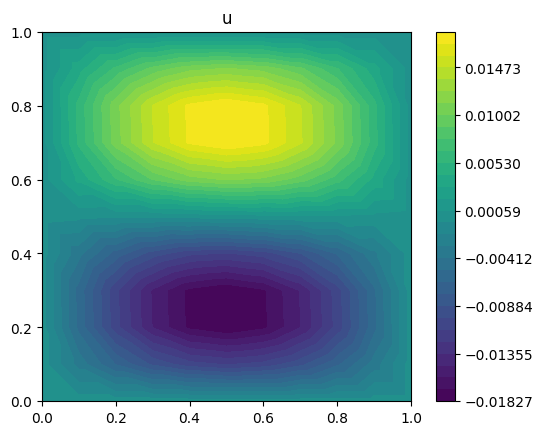

In [1]:
%matplotlib inline

from firedrake import *
from tlm_adjoint.firedrake import *
from firedrake.pyplot import tricontourf

import matplotlib.pyplot as plt
import numpy as np

mesh = UnitSquareMesh(10, 10)
X = SpatialCoordinate(mesh)
space = FunctionSpace(mesh, "Lagrange", 1)
test, trial = TestFunction(space), TrialFunction(space)
m = Function(space, name="m").interpolate(sin(pi * X[0]) * sin(2 * pi * X[1]))


def forward(m):
    u = Function(space, name="u")
    solve(inner(grad(trial), grad(test)) * dx == -inner(m, test) * dx,
          u, DirichletBC(space, 0.0, "on_boundary"))

    J = Functional(name="J")
    J.assign(((1.0 - X[0]) ** 4) * u * u * dx)
    return u, J


u, J = forward(m)

print(f"{J.value=}")


def plot_output(u, title):
    r = (u.dat.data_ro.min(), u.dat.data_ro.max())
    eps = (r[1] - r[0]) * 1.0e-12
    p = tricontourf(u, np.linspace(r[0] - eps, r[1] + eps, 32))
    plt.gca().set_title(title)
    plt.colorbar(p)
    plt.gca().set_aspect(1.0)


plot_output(u, title="u")

## First order adjoint

We can differentiate a functional respect to $m$ using `compute_gradient`. Specifically we compute the derivative of $\hat{J} = J \circ \hat{u}$, where $\hat{u}$ is the function which maps from the control $m$ to the solution to the discretized Poisson problem.

When we compute a derivative of a functional with respect to a finite element discretized function using the adjoint method the result is not a function, but is instead a member of a dual space. Here we have $m \in V$, and the derivative of $\hat{J}$ with respect to $m$ is a member of the associated dual space $V^*$. In order to visualize this derivative we first need to map it to $V$. We can do this using a Riesz map. This is not uniquely defined, but here we choose to define a Riesz map using the $L^2$ inner product.

Being precise the function we visualize, $g^\sharp \in V$, is defined such that

$$\forall \zeta \in V \qquad \left. \frac{d \hat{J} \left( m + \alpha \zeta \right)}{d \alpha} \right|_{\alpha = 0} = \int_\Omega \zeta g^\sharp,$$

where $\alpha$ is a scalar.

J.value=np.float64(9.711060188691796e-06)


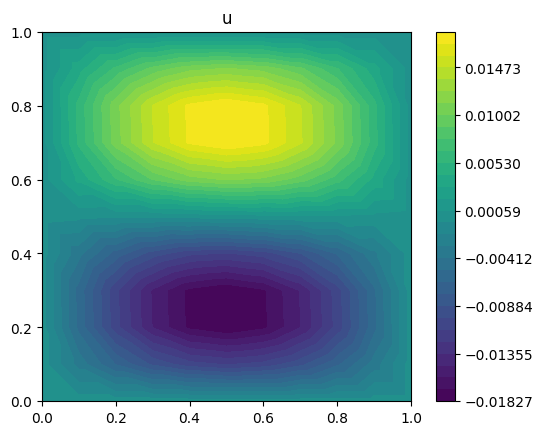

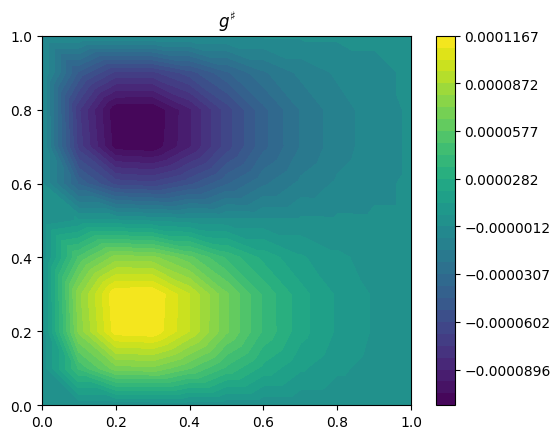

In [2]:
reset_manager()

start_manager()
u, J = forward(m)
stop_manager()

print(f"{J.value=}")
plot_output(u, title="u")


dJdm = compute_gradient(J, m)
plot_output(dJdm.riesz_representation("L2"), title=r"$g^\sharp$")

## Hessian action

Next we seek to differentiate $\hat{J}$ twice with respect to $m$. However the second derivative defines a *bilinear* operator. This can be represented as a matrix &ndash; a Hessian matrix &ndash; but the number of elements in this matrix is equal to the *square* of the number of degrees of freedom for $m$.

Instead of computing the full second derivative we can compute its action on a given direction $\zeta \in V$. The degrees of freedom associated with the result define the action of the Hessian matrix on a vector &ndash; specifically the action of the Hessian matrix on the vector consisting of the degrees of freedom for $\zeta$.

We do this in two stages. First we compute a directional derivative,

$$\left. \frac{d \hat{J} \left( m + \alpha \zeta \right)}{d \alpha} \right|_{\alpha=0},$$

computed using the tangent-linear method. We consider the case where $\zeta = 1$.

J.value=np.float64(9.711060188691796e-06)
dJdm_zeta.value=np.float64(1.15806935648437e-06)


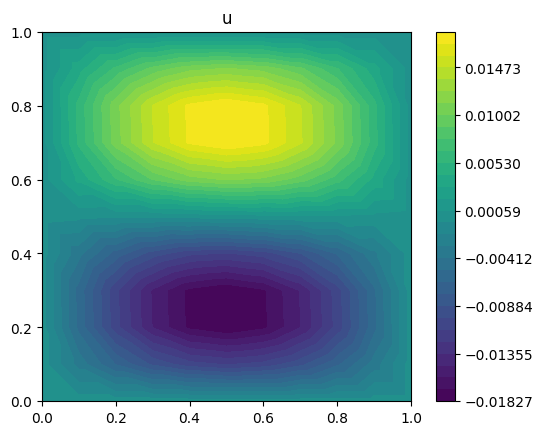

In [3]:
reset_manager()

zeta = Function(space).interpolate(Constant(1.0))
configure_tlm((m, zeta))

start_manager()
u, J = forward(m)
stop_manager()

print(f"{J.value=}")
plot_output(u, title="u")

dJdm_zeta = var_tlm(J, (m, zeta))
print(f"{dJdm_zeta.value=}")

Next we compute the derivative of *this* derivative using the adjoint method.

Again we need to remember that the result is a member of the dual space $V^*$, and is not a function, so we again use a Riesz map to visualize it. Here we use the same Riesz map as before, defined using the $L^2$ inner product.

Being precise the function we visualize, $h^\sharp \in V$, is defined such that

$$\forall \chi \in V \qquad \left. \frac{\partial^2 \hat{J} \left( m + \alpha \zeta + \beta \chi \right)}{\partial \beta \partial \alpha} \right|_{\alpha = 0, \beta = 0} = \int_\Omega \chi h^\sharp,$$

where $\zeta \in V$ defines the direction on which the action is computed, and $\alpha$ and $\beta$ are scalars.

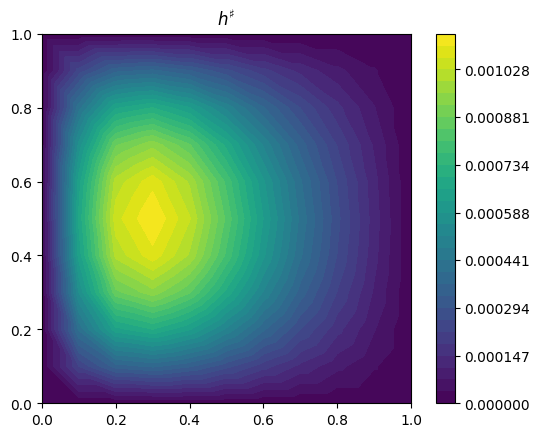

In [4]:
d2Jdm2_zeta = compute_gradient(dJdm_zeta, m)
plot_output(d2Jdm2_zeta.riesz_representation("L2"), title=r"$h^\sharp$")